# Customer Lifetime Value Model using PYMC
- Justin Wall

## Goals
Build Customer Lifetime Value model
- Distinguish active customers from inactive customers
- Generate transaction forecasts for individual customers
- Predict the purchase volume of the entire customer base

Tools
- PYMC for probabilistic programming
- Lifetimes for the dataset, but it's not a maintained library so we will skip it for the actual implementation

<br>

***

<br>

## Import Data & Libraries

In [24]:
import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt 
import seaborn as sns
import arviz as az

import pymc as pm
import pytensor.tensor as pt
from lifetimes import BetaGeoFitter
from lifetimes.datasets import load_cdnow_summary

In [16]:
df = load_cdnow_summary(index_col=[0])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2357 entries, 1 to 2357
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   frequency  2357 non-null   int64  
 1   recency    2357 non-null   float64
 2   T          2357 non-null   float64
dtypes: float64(2), int64(1)
memory usage: 73.7 KB


In [17]:
df.head()

,frequency,recency,T
ID,,,
1,2,30.43,38.86
2,1,1.71,38.86
3,0,0.00,38.86
4,0,0.00,38.86
5,0,0.00,38.86


<br>

***

<br>

## Exploratory Data Analysis

In [18]:
# Count of time periods the customer has a purchase in
df['frequency'].value_counts(dropna=False).head(10)

frequency
0     1411
1      439
2      214
3      100
4       62
5       38
6       29
7       23
8        7
10       5
Name: count, dtype: int64

In [19]:
# Duration between first and last purchase
df['recency'].value_counts(dropna=False).head(10)

recency
0.00     1411
1.57       10
25.86       9
2.14        9
20.86       9
27.71       9
21.14       9
7.57        8
24.43       8
2.00        8
Name: count, dtype: int64

In [20]:
# Duration between first purchase and now
df['T'].value_counts(dropna=False).head(10)

T
33.71    43
29.86    40
31.14    37
32.14    36
34.14    36
30.86    36
34.00    36
36.14    35
32.29    35
32.00    34
Name: count, dtype: int64

<br>

***

<br>

## CLV Modeling

### BG/NBD Model for predicting the count of future transactions
Beta Goemetric Negative Binomial Distribution shows transactions over time and tells when customers become inactive. All we need here is recency and frequency during a time period as a customer. Customers will then purchase at a random interval during the time range and have a certain probability of becoming inactive after that.

In [33]:
# Get some variables together here
n = df.shape[0] # number of customers
x = df['frequency'].values # number of repeat purchases
t_x = df['recency'].values # duration between first and last purchase
T = df['T'].values # duration between first purchase and now
int_vec = np.vectorize(int) # vectorize the int function
x_zero = int_vec(x>0) # indicator for whether the customer has purchased more than once

In [34]:
# It's always difficult to start at the top of the PYMC model, so I have numbers below to tell you where to start to best understand this model.
with pm.Model() as model_full:

    # Hyperpriors for the Gamma distribution parameters - lambda's prior
    a = pm.HalfNormal(name="a", sigma=10)
    b = pm.HalfNormal(name="b", sigma=10)
    # 'a' and 'b' are the hyperparameters for the Beta distribution of 'p'.
    # The HalfNormal distribution ensure these values are non-negative, with a standard deviation of 10.

    # Hyperpriors for the Beta distribution parameters (p's prior)
    alpha = pm.HalfNormal(name="alpha", sigma=10)
    r = pm.HalfNormal(name="r", sigma=10)
    # 'alpha' and 'r' are the hyperparameters for the Gamma distribution of 'lambda'.
    # Again, the HalfNormal distribution ensure these values are non-negative, with a standard deviation of 10.

    # Define customer-level latent variables
    lam = pm.Gamma(name="lam", alpha=r, beta=alpha, shape=len(df))
    # 'lam' (lambda) represents the purchase rate for each customer.
    # Modeled as a Gamma distribution with hyperparameters 'r' and 'alpha'.
    # 'shape=len(df)' ensures that we have a separate lambda for each customer.

    p = pm.Beta(name="p", alpha=a, beta=b, shape=len(df))
    # 'p' represents the dropout probability for each customer.
    # Modeled as a Beta distribution with hyperparametesr 'a' and 'b'.
    # 'shape=len(df)' ensures a separate dropout probability for each customer.

    # Define the custom log-likelihood function
    def logp(x, t_x, T, x_zero):
        # x: Number of repeat transactions per customer
        # t_x: Recency of the last purchase
        # T: Duration of observation for each customer
        # x_zero: Indicator for customers with no repeat purchases (x == 0)

        # Term A: Contribution to likelihood from observed transactions
        log_term_a = x * pt.log(1 - p) + x * pt.log(lam) - t_x * lam
        # `log_term_a` calculates the log-probability of observed purchases.
        # - `pt.log(1 - p)`: Log of the probability the customer remains active after each purchase.
        # - `pt.log(lam)`: Log of the purchase rate.
        # - `-t_x * lam`: Accounts for the time elapsed since the last purchase.

        # Term B: Contribution from survival/dropout
        term_b_1 = -lam * (T - t_x)
        term_b_2 = pt.log(p) - pt.log(1 - p)
        # `term_b_1`: Accounts for the probability of no purchases between `t_x` and `T`.
        # `term_b_2`: Log-odds of dropout.

        log_term_b = pm.math.switch(
            x_zero, pm.math.logaddexp(term_b_1, term_b_2), term_b_1
        )
        # `log_term_b`: Handles two cases:
        # - If `x_zero` is True (no repeat purchases), combines dropout and survival likelihoods.
        # - Otherwise, only considers survival likelihood.

        return pt.sum(log_term_a) + pt.sum(log_term_b)
        # Summing the log-likelihood terms across all customers.

    # Define the likelihood function
    likelihood = pm.Potential(
        name="likelihood",
        var=logp(x=x, t_x=t_x, T=T, x_zero=x_zero),
    )
    # `pm.Potential` allows defining a custom likelihood function.
    # `logp` calculates the log-likelihood for the observed data.


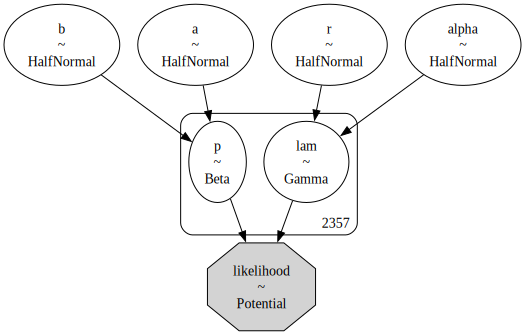

In [35]:
# Visualize the model as graph to understand the relationships between variables
pm.model_to_graphviz(model=model_full)

In [ ]:
# This model should align with what would be obtained from the `lifetimes` package.
with model_full:
    trace_full = pm.sample(
        tune=2000,
        draws=4000,
        chains=4,
        target_accept=0.95,
        # nuts_sampler="numpyro",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, alpha, r, lam, p]


Output()

<br>

***

<br>

## Sources
- https://juanitorduz.github.io/bg_nbd_pymc/
    - PYMC: Dr. Juan Camilo Orduz, full explanation of CLV probabilistic modeling using PYMC
- https://towardsdatascience.com/measuring-customers-value-using-python-lifetimes-d8b19a04e9c1
    - Great explanation of BG/NBD modeling, but uses lifeitmes to train. Then nice explanation of testing the model.
- 

# 